# Project 1

In this project we are going to estimate the concentration of DIC in the ocean with some given initial conditions. Throughout the project we will refer to equations from the assignment text, by writing "equation (number)". We have included an appendix with some extra plots and calculations we found interesting. 

**Importing necessary libraries:**

In [1]:
# Matplotlib for plotting
%matplotlib inline
from matplotlib import pyplot as plt

# Numpy for almost everything
import numpy as np

# Some scipy functions for sparse diagonal matrices
from scipy.sparse import diags

# scipy function to numerically calculate integral
from scipy.integrate import simps

# just-in-time (jit) compiler from numba, to speed up the loop in the TDMA solver
from numba import jit

**Importing the Tri-Diagonal Matrix Algorithm (TDMA):**

This algorithm is given in the initial help code for the project, and is a function that solves tri-diagonal matrix equations.

In [2]:
# just-in-time (jit) compiler from numba, to speed up the loop in the TDMA solver
@jit(nopython = True)
def tdma_solver(a, b, c, d):
    N = len(d)
    c_ = np.zeros(N-1)
    d_ = np.zeros(N)
    x  = np.zeros(N)
    c_[0] = c[0]/b[0]
    d_[0] = d[0]/b[0]
    for i in range(1, N-1):
        c_[i] = c[i]/(b[i] - a[i-1]*c_[i-1])
    for i in range(1, N):
        d_[i] = (d[i] - a[i-1]*d_[i-1])/(b[i] - a[i-1]*c_[i-1])
    x[-1] = d_[-1]
    for i in range(N-2, -1, -1):
        x[i] = d_[i] - c_[i]*x[i+1]
    return x

def tdma(A, b):
    # Solves Ax = b to find x
    # This is a wrapper function, which unpacks
    # A from a sparse diagonal matrix structure into separate diagonals,
    # and pass them to the numba-compiled solver defined above.
    x = tdma_solver(A.diagonal(-1), A.diagonal(0), A.diagonal(1), b)
    return x

**Defining the matrix function and the equilibrium concentration equation:**

The function "matrixes" calculates the diagonals for the matrixes L and R, and then defines L and R; two tri-diagonal matrixes that is used to find the concentrations of DIC in upcoming calculations. The matrixes are defined by equation (26). The function calculates $K'_{n}$, $\alpha$ and $\Gamma$ by equation (25).
The function "C_eq" returns the equilibrium concentrations with the partial pressure of CO2 as input using equation (4).

In [3]:
def matrixes(K,dt,dz):
    alpha=dt/(2*(dz**2))
    K_marked=np.zeros(N)
    for n in range(1,len(K_marked)):
        K_marked[n]=K[n+1]-K[n-1]
    
    Gamma=2*alpha*kw*dz*(1-((K[1]-K[0])/(2*K[0])))
    
    # Creating diagonals for L
    L_main=np.ones(N+1)
    L_main[0]=1+2*alpha*K[0]+Gamma
    for i in range(1,len(L_main)):
        L_main[i] =1+(2*alpha*K[i])
    
    L_upper = np.ones(N)
    L_upper[0]=-2*alpha*K[0]
    for i in range(1,len(L_upper)):
        L_upper[i]=((-alpha/4)*K_marked[i])-(alpha*K[i])
        
    L_lower = np.ones(N)
    L_lower[N-1]=-2*alpha*K[N]
    for i in range(len(L_lower)-1):
        L_lower[i]=((alpha/4)*K_marked[i+1])-(alpha*K[i+1])

    #Creating diagonals for R
    R_main=np.ones(N+1)
    R_main[0]=1-2*alpha*K[0]-Gamma
    for i in range(1,len(R_main)):
        R_main[i]=1-(2*alpha*K[i])
    
    R_upper = np.ones(N)
    R_upper[0]=2*alpha*K[0]
    for i in range(1,len(R_upper)):
        R_upper[i]=((alpha/4)*K_marked[i])+(alpha*K[i])
    
    R_lower = np.ones(N)
    R_lower[N-1]=2*alpha*K[N]
    for i in range(len(R_lower)-1):
        R_lower[i]=((-alpha/4)*K_marked[i+1])+(alpha*K[i+1])

    # Creating sparse matrices
    # Give a list of the diagonals, and a corresponding list of offsets
    # offset of 0 is the main diagonal, offset -1 is the first lower diagonal, etc.
    # (scipy.sparse.diags was imported above)
    L = diags([L_upper, L_main, L_lower], offsets = [1, 0, -1])
    R = diags([R_upper, R_main, R_lower], offsets = [1, 0, -1])
    
    return R,L,Gamma

#Creating a function that returns the equilibrium concentrations with the partial pressure of CO2 as input. 
def C_eq(p_CO2):
    Ceq=H*p_CO2
    return Ceq

# Problem 1

In problem one we will calculate the concentrations of DIC in the ocean as a function of depth and time. We assume that the ocean is 100 m deep, and that there is no initial concentration of DIC. We will do the calculations over a period of 180 days. 
We are also going to plot the concentration in different ways. 

**Defining variables and constants for problem 1:**

In [4]:
#Constants
N=999                          #steps
z_max=100                      #[m] Depth of ocean
t_max=180*60*60*24             #[s] 180 days
kw=6.97*10**(-5)               #[m/s]  Mass transfer coefficient (eq 5)
secperday = 60*60*24           #[s] 1 day
H=5060                         #[mol/(m^3*atm)] 
p_CO2=415*10**(-6)             #[atm] Partial pressure CO2 in the atmosphere

#Creating lists of time and depth
z=np.linspace(0,z_max,N+1)     
dz=z[1]-z[0]                   
t=np.linspace(0,t_max,N+1) 
dt=t[1]-t[0]

#constants for diffusivity K:
K_0=10**(-3)                   #[m^2/s]
K_a=2*10**(-2)                 #[m^2/s]
K_b=5*10**(-2)                 #[m^2/s]
z_a=7                          #[m]
z_b=10                         #[m]


**Final calculations for problem 1:**

First we calculate the diffusivity constant K, using equation (6). Then we create the tridiagonal matrixes R and L, and get the value for the equilibirum concentration of DIC using the functions defined above. We define S by equation (24). We then create an empty matrix and finally use TDMA to solve the matrix equation to find the concentrations. This gives a matrix with all the concentrations in regards to depth and time. Below we have some plots to show how the concentrations change over time and depth.

In [5]:
#Defining diffusivity K:
K=np.zeros(N+1)
for i in range(len(K)):
    K[i]=K_0+K_a*(z[i]/z_a)*np.exp(-z[i]/z_a)+K_b*((z_max-z[i])/(z_b))*np.exp(-(z_max-z[i])/z_b)   #(eq. 6)

#Creating matrixes R and L:
R,L,Gamma=matrixes(K,dt,dz)

#Equilibrium concentration:
Ceq=C_eq(p_CO2)             #[mol/m^3]

#Defining S:
S=np.zeros(N+1)
S[0]=2*Gamma*Ceq
S_t=np.transpose(S)

#Creating a matrix for concentrations, where the first row is zeros, 
#and the other rows are changed below in the for-loop
Concentration1=np.zeros(shape=(N+1,N+1))

# For solving an equation such as L*C1 = R*C0, to find C1 when we know C0,
# we then first calculate the matrix-vector product R*C0, using the built-in
# method .dot() of the diagonal sparse array structure
# Then we solve the linear equation system L*C1 = V to find C1
for i in range(N):
    V=R.dot(Concentration1[i])+S_t    #S is constant in problem 1 (eq 27)
    Concentration1[i+1]=tdma(L,V)

**Plot of the highest and lowest concentrations of DIC as function of time:**

In addition to plotting the highest and lowest concentrations, we plot the difference to visualise further how quickly the concentriation gets distributed evenly in the 100 m deep ocean. In the comments below we will discuss what we see. Later we will check if ths holds for deeper waters. 

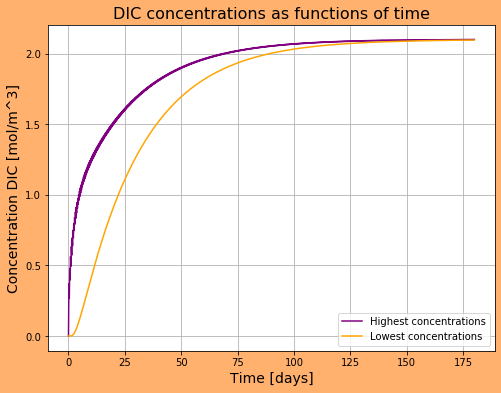

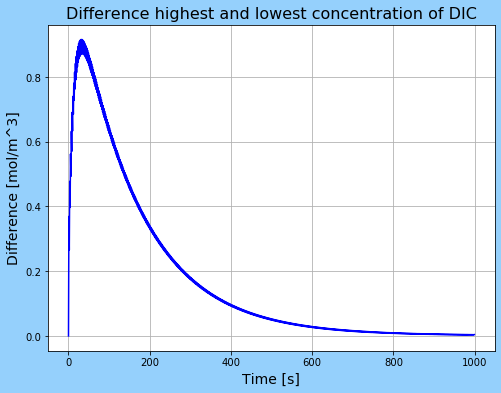

In [6]:
#Creating lists of highest and lowest concentrations for each row (time)
highCon=np.zeros(N+1)
lowCon=np.zeros(N+1)
for i in range(N+1):
    C=Concentration1[i]
    C_max=np.amax(C)
    C_min=np.amin(C)
    highCon[i]=C_max
    lowCon[i]=C_min

#Creating a list of the difference between the highest and lowest concentration for earch row (time)
diff=np.zeros(N+1)
for i in range(N+1):
    diff[i]=highCon[i]-lowCon[i]

#Plotting the highest and lowest concentrations 
fig=plt.figure(figsize=(8,6))
fig.patch.set_color("xkcd:apricot")
plt.plot(t/secperday,highCon,'purple',label="Highest concentrations")
plt.plot(t/secperday,lowCon,'orange',label="Lowest concentrations")
plt.legend()
plt.xlabel("Time [days]",size=14)
plt.ylabel("Concentration DIC [mol/m^3]",size=14)
plt.title("DIC concentrations as functions of time",size=16)
plt.grid()
plt.show()

#Plotting the difference
fig=plt.figure(figsize=(8,6))
fig.patch.set_color("xkcd:light blue")
plt.plot(diff,"blue")
plt.title("Difference highest and lowest concentration of DIC",size=16)
plt.xlabel("Time [s]",size=14)
plt.ylabel("Difference [mol/m^3]",size=14)
plt.grid()
plt.show()


**Plot of the concentration of DIC as a function of depth at different times:**


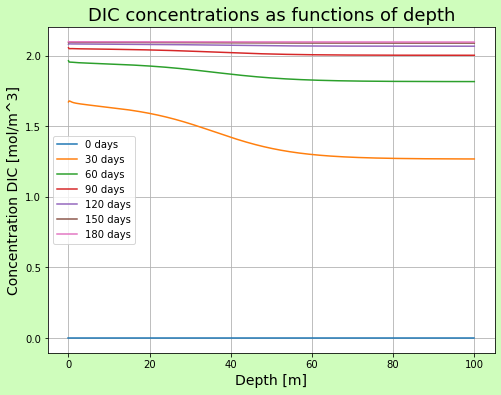

In [7]:
#PLotting the concentration of DIC in regards to depth for 7 equidistant times
i_vals=np.linspace(0,N,7)
fig=plt.figure(figsize=(8,6))
fig.patch.set_color("xkcd:very pale green")

for i in i_vals:
    i=int(i)
    concentrations=Concentration1[i]
    plt.plot(z,concentrations,label=(f'{int(round(t[i]/secperday))} days'))
plt.legend()
plt.xlabel("Depth [m]",size=14)
plt.ylabel("Concentration DIC [mol/m^3]",size=14)
plt.title("DIC concentrations as functions of depth",size=18)
plt.grid()
plt.show()

**Comments:**

As the times we have plotted for are equally distributed over the interval, we can see that the concentration quickly changes in the start, and stabilizes at around 2.1 mol/m^3 for all depths. 

Since the concentration stabilizes within the 180 days we calculated for, we think the water at 100m depth will be in sync with the atmospheric changes in CO2 concentration, as it only changes slowly from year to year. The plot that shows the difference between the highest and lowest concentrations, also shows that the difference will decrease rapidly, which confirms the syncronicity. 

# Problem 2

In problem two we will calculate the concentrations of DIC in the ocean as a function of depth and time. We assume that the ocean is 4000 m deep, and that the initial concenctration of DIC in the ocean is in equilibirum with the atmospheric concentration of $CO_{2}=415$ppm. We are going to plot the concentration at different times, and the diffusivity constant, both as a functions of depth. We will then compare these plots to figure 2 in the assignment text. 

Afterwards we will plot the total mass of DIC as a function of time, for the years 2020-2030. Then we will find the average absorbtion per year. Finally we will compare the result to the yearly absobtion that researchers have estimated, $2.5\cdot10^{15}$ g, and comment on some possible reasons for the deviation. 

**Defining variables and constants for problem 2:**


In [8]:
#Constants
N=5000                        #steps
C0=H*414*10**(-6)             #[mol/m^3] initial DIC concentration
depth_max=4000                #[m] 
time_max=10*365*24*60*60      #[s] 10 years
secperyear=365*24*60*60       #[s] 1 year 

#Creating lists of time and depth
depth=np.linspace(0,depth_max,N+1) 
time=np.linspace(0,time_max,N+1)   
dt=time[1]-time[0]
dz=depth[1]-depth[0]

#Constants for diffusivity K
K_0=10**(-4)                  #[m^2/s]
K_1=10**(-2)                  #[m^2/s]
a=0.5                         #[1/m]
z_0=100                       #[m]


**Calculations for problem 2:**

First we calculate the diffusivity constant K, using equation (7). Then we create the tridiagonal matrixes R and L, and get the value for the equilibirum concentration of DIC, in the same way as earlier. However, in this problem the partial pressure of $CO_{2}$ in the atmosphere changes with time. This will in return make the S-matrix change with time. We define S by equation (24). We then create an empty matrix and finally use TDMA to solve the matrix equation to find the concentrations. We also have to add the initial concentration, as it is no longer zero. This gives a matrix with all the concentrations in regards to depth and time. Below we have some plots to show how the concentrations change over time and depth.

In [9]:
#Defining diffusivity K:
K=np.zeros(N+1)
for i in range(len(K)):
    K[i]=K_1+(K_0-K_1)/(1+np.exp(-a*(depth[i]-z_0)))  #eq 7
    
#Creating the matrixes R and L
R,L,Gamma=matrixes(K,dt,dz)

#Creating a list of partial pressures of CO2
p_CO2=np.zeros(N+1)   
for i in range(N+1):
    p_CO2[i]=415*10**(-6)+2.3*10**(-6)*time[i]/secperyear

#List of equilibrium concentrations for different times
Ceq2=C_eq(p_CO2)

#Creating the S-matrix
S=np.zeros(shape=(N+1,N+1))
for i in range(N+1):
    S[i][0]=2*Gamma*Ceq2[i] #column vector (transposed)

#Creating a matrix of concentrations 
Concentration2=np.zeros(shape=(N+1,N+1))
Concentration2[0]=C0
for i in range(N):
    V=R.dot(Concentration2[i])+(1/2)*(S[i]+S[i+1]) 
    Concentration2[i+1]=tdma(L,V)


**Plotting the concentrations of DIC and the diffusivity constant as functions of depth:**

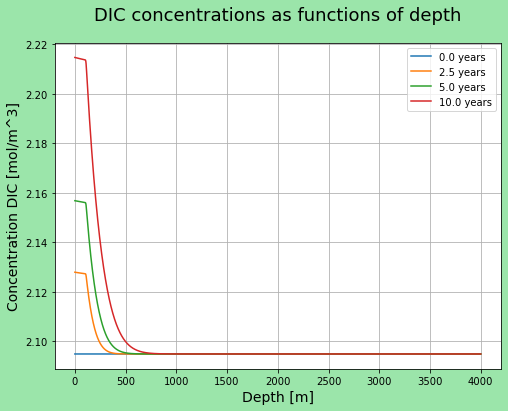

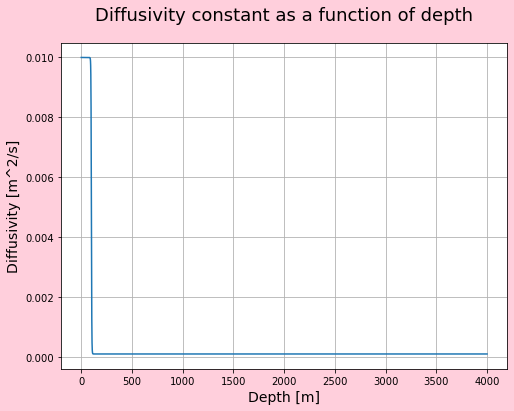

In [10]:
#PLotting the concentration of DIC in regards to depth for 0, 2.5, 5 and 10 years
i_vals=(0,N/4,N/2,N)
fig=plt.figure(figsize=(8,6))
fig.patch.set_color("xkcd:hospital green")

for i in i_vals:
    i=int(i)
    concentrations=Concentration2[i]
    plt.plot(depth,concentrations,label=(f'{round(time[i]/(60*60*24*365),1)} years'))

plt.legend()
plt.xlabel("Depth [m]",size=14)
plt.ylabel("Concentration DIC [mol/m^3]",size=14)
plt.title("DIC concentrations as functions of depth",size=18,y=1.05)
plt.grid()
plt.show()

#Plotting K as a function of depth
fig=plt.figure(figsize=(8,6))
fig.patch.set_facecolor("xkcd:pale pink")
plt.plot(depth,K)
plt.title("Diffusivity constant as a function of depth",size=18,y=1.05)
plt.xlabel("Depth [m]",size=14)
plt.ylabel("Diffusivity [m^2/s]",size=14)
plt.grid()
plt.show()


**Comment:**

In the graphs above we see an abrupt change happening at around 100 metres depth. This seems to correspond with the transition between the surface mixed layer and the deep ocean that we see in figure 2. In the surface mixed layer there is turbulence which helps the CO2-absorbtion, and while the turbulence brings some CO2 to the deeper ocean layers, it will not succeed in bringing it very deep. This agrees with the rapid decrease in concentration below 100 metres depth. 
The diffusivity also decreases a lot at the same depth. Since the diffusivity has a big impact on the absorption of CO2, this corresponds well. 

In problem 1 we concluded that the absorbtion of CO2 into the ocean was in sync with the atmospheric changes. In these calculations we only considered depths up to 100 metres, the surface mixed layer. In the calculations in which we have included depths up to 4000 metres we see the same behavior for the surface mixed layer, but the deeper layers will not be affected as much by atmospheric changes. This shows a coherence between the two problems, as they both give the same impression of the surface mixed layer's behavior.

**Finding total mass using integration and plotting it as function of time:**

Below we integrate the concentration over a 1m by 1m column, and mutliply by the total surface area of the ocean, as well as the molar mass of carbon. We do this to find the total mass of DIC in the ocean as a function of time, and then we plot it. 

We also find the average mass absorption per year, and then comment on possible reasons why the number we find is different from the number estimated by researchers (from the assignment text). 

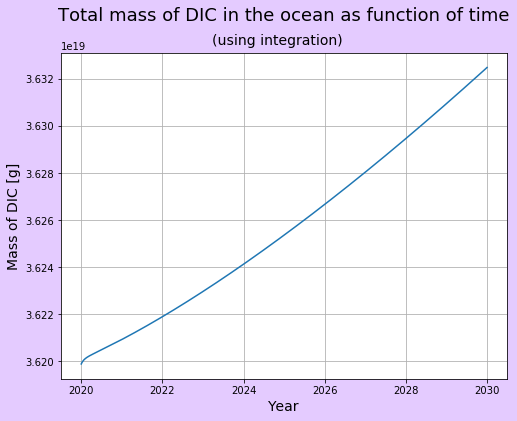

In [11]:
#Some more constants
M_C=12                  #[g/mol] Molar mass carbon
A=360*10**12            #[m^2]   Area of ocean

#Solving concentration integral to find mass
integral=simps(Concentration2*A*M_C,x=depth,axis=1) 

#Plotting total mass 
fig=plt.figure(figsize=(8,6))
fig.patch.set_color("xkcd:pale lilac")
plt.plot(time/secperyear+2020,integral)
plt.title("Total mass of DIC in the ocean as function of time",size=18,y=1.08)
plt.figtext(.5,.90,"(using integration)", fontsize=14,ha="center")
plt.xlabel("Year",size=14)
plt.ylabel("Mass of DIC [g]",size=14)
plt.grid()
plt.show()

In [12]:
#The average mass absorbed by the ocean per year
mass_start=integral[0]
mass_end=integral[N]
average_absorbtion=(mass_end-mass_start)/10   
print(f'The calculated average absorbtion per year is: {average_absorbtion} grams')


The calculated average absorbtion per year is: 1.2594584409709364e+16 grams


**Comments:**

Researchers have estimated that the oceans absorb anthropogenic $CO_{2}$ at a rate of $2.57\cdot10^{15}$ g per year. Our result is $\approx1.26\cdot10^{16}$ g per year, which corresponds to roughly a 20% deviation. To be able to estimate the concentration of DIC in the ocean a lot of simplifications were made, which probably impacted the result. The simplifications were as follows:

<ul> 
<li> Water column model where everything is assumed constant in the horizontal direction. One-dimentional model. 
<li> Assumed constant depth over the whole surface area of the ocean.
<li> $CO_{2}$ is immediately transformed into DIC.
<li> Assumed linear relationship between $P_{CO_{2}}$ and $[DIC]_{eq}$.
<li> Applied Henry's law directly to DIC instead of $CO_{2}$.
<li> Assumed $CO_{2}$ as ideal gas.
<li> Assumed average $[DIC]$ at sea surface level (2.1 $mol/m^2$). 
<li> Simplifications for the diffusivity constant $K(z)$.  
<li> Mass transfer process simplified so that the mass transfer coefficient $k_{w}$ depends only on wind speed and a constant. 
<li> Assumed constant wind speed of $10 m/s$ for $k_{w}$.
<li> Neglected plants, animals, ocean currents and temperature, which can affect the amount of DIC in the ocean. 
</ul>

The simplification of the ocean into a one dimentional model might have the most influence on the result, because a lot of the calculations are based on the model. Diffusion, as an example, is not one dimentional, but the diffusivity constant we have used depends only on depth. In reality the diffusivity constant will depend on local conditions, such as wind, temperature and ocean currents. 
The assumption that $CO_{2}$ is immediately transformed into DIC might not have a significant effect on the result, as the time it actually takes transforming is much smaller than the time period of our calculations. 

It is difficult to estimate in which direction each of the simplifictions affected the result, but in total we got a larger number than the researchers estimated. 
The fact that we neglected plants and animals in the ocean, might have made our resulting concentration higher than the realistic concentration. Plants and animals contribute to an organic carbon concentration, which again will affect the absorbtion of DIC. If there is a lot of carbon already in the ocean, then less will be absorbed. 

Overall, this is a good way to simulate and visualise the absorbsion of DIC into the ocean, as long as we have the simplifications in mind when looking at the result. 



# Appendix

**To visualize the concentration changes we have plotted our matrixes from each of the problems underneath:**

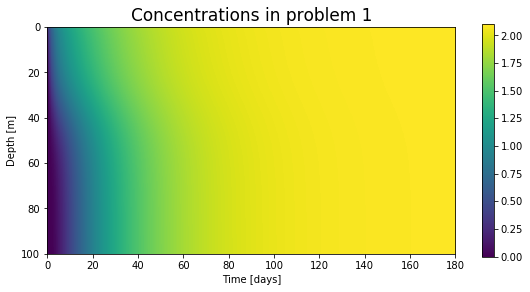

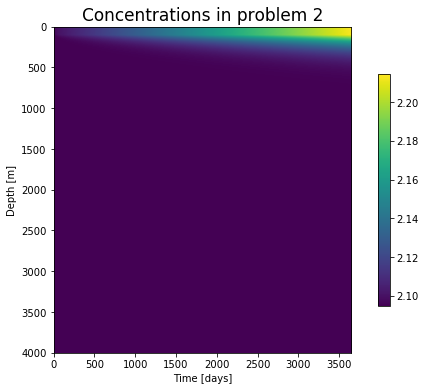

In [13]:
#Problem 1
plt.figure(figsize=(8,6))
plt.imshow(np.transpose(Concentration1),origin="upper",extent=[0,180,100,0])
plt.title("Concentrations in problem 1",size=17)
plt.xlabel("Time [days]")
plt.ylabel("Depth [m]")
plt.colorbar(fraction=0.026,pad=0.06)
plt.show()

#Problem 2
plt.figure(figsize=(8,6))
plt.imshow(np.transpose(Concentration2),origin="upper",extent=[0,10*365,4000,0])
plt.title("Concentrations in problem 2",size=17)
plt.xlabel("Time [days]")
plt.ylabel("Depth [m]")
plt.colorbar(fraction=0.026,pad=0.06)
plt.show()

**Comment:**

These plots enhance our impression of how the diffusion of DIC in shallow versus deep ocean is very different. Our conclusion on the matter was that water of 100m depth is in sync with the atmosphere, while water of 4000m depth is not. This is apparent from these plots. Even though the plot from problem 2 is over a much longer period of time, the deeper layers are basically unaffected. 

**Finding total mass using mass flux**

We chose to recalculate the total mass using the inital mass of DIC and the mass flux, to see if we got the same results. As you can see below, the result is slighly different, but the overall shape is the same. We think it could be because the timesteps are quite big. However, we are content with the similarities between the methods. 

We also printed out the absorbed mass per year, just to show that there are yearly changes. 

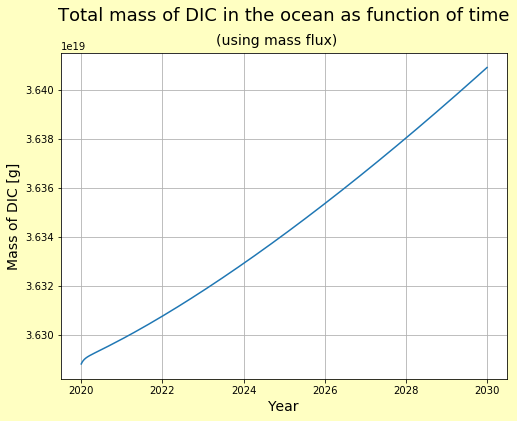

Absorbed year 1: 1.0135812157725212e+16 grams
Absorbed year 2: 9375162620747292.0 grams
Absorbed year 3: 1.0340815890671632e+16 grams
Absorbed year 4: 1.1153131425052092e+16 grams
Absorbed year 5: 1.18658027245912e+16 grams
Absorbed year 6: 1.2508034768594056e+16 grams
Absorbed year 7: 1.3097208297851016e+16 grams
Absorbed year 8: 1.3644590311731776e+16 grams
Absorbed year 9: 1.4157961958492752e+16 grams
Absorbed year 10: 1.4642958982155888e+16 grams


In [14]:
m=(2.1*A*depth_max*12)  #[g]     Initial mass

#Creating a list of the mass for each time step 
m_list=np.zeros(N+1)
for i in range(N+1):
    j=-kw*(Concentration2[i,0]-Ceq2[i]) #mass flux
    m+=j*A*M_C*dt
    m_list[i]=m

#Plotting total mass
fig=plt.figure(figsize=(8,6))
fig.patch.set_color("xkcd:cream")
plt.plot(time/secperyear+2020,m_list)
plt.title("Total mass of DIC in the ocean as function of time",size=18,y=1.08)
plt.figtext(.5,.90,"(using mass flux)", fontsize=14,ha="center")
plt.xlabel("Year",size=14)
plt.ylabel("Mass of DIC [g]",size=14)
plt.grid()
plt.show()

#Creating a list of the mass for each time step 
m_list=np.zeros(N+1)
diff=0
for i in range(N+1):
    j=-kw*(Concentration2[i,0]-Ceq2[i]) #mass flux
    diff+=j*A*M_C*dt
    m_list[i]=diff
    
for i in range(1,11):
    print(f'Absorbed year {i}: {m_list[int(i*N/10)]-m_list[int((i-1)*N/10)]} grams')
    